# CSCK507 Mid Module - Toxic Comment Classification Challenge

## Table of Contents
[Section 1. Introduction](#introduction)
- [Import Dependencies](#import-dependencies)
- [Loading Kaggle dataset into DataFrame](#import-dependencies)
- [Initialise SpaCy Model ](#import-dependencies)

[Section 2. Data Exploration & Analysis](#data-exploration-&-analysis)
- [Dataset Alignment](#data-preprocessing)
- [Data Preprocessing](#data-preprocessing)
- [Tokenisation & Lemmatisation](#data-preprocessing)
- [Combining Tokenised Data and Labels for Training and Test Dataset](#data-preprocessing)
  
  [2.1 Task 1 Requirements](#data-exploration-&-analysis)
    - [Number of Sentences & Tokens Per Class](#data-preprocessing)
    - [Understanding the Most Common Words](#data-preprocessing)
    - [Data Imbalance](#data-imbalance)
  
[Section 3. Feature Extraction Methods](#data-exploration-&-analysis)
- [TF-IDF Implementation](#data-preprocessing)

[Section 4. Machine Learning Model Development](#data-exploration-&-analysis)

[Section 5. Model Evaluation](#data-exploration-&-analysis)


---
## Section 1. Introduction

Originating in 2018, this challenge revolves around classifying different levels of toxicity in online comments. The dataset from the inaugural competition is utilized to analyze and evaluate the performance of various machine learning algorithms in categorizing six types of toxicity. The primary goal is not only to find an optimal solution but to understand the process of evaluating machine learning algorithms' performance in a classification task. This individual assessment involves data analysis, algorithm selection, and the exploration of feature extraction methods to uncover insights into the nuances of toxic comment classification.

The Toxic Comment Classification Challenge and dataset can be obtained from Kaggle, here: 

### Importing Dependencies

In [22]:
# General
import pandas as pd 
import numpy as np
import warnings

# For Data Preprocessing
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords
import nltk
import re  

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# For Feature Extraction  
import spacy
import string 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   

# For Machine Learning
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier,XGBRFClassifier

### Load Kaggle dataset into DataFrame

In [5]:
df = pd.read_csv('dataset/train.csv')
df_test_labels = pd.read_csv('dataset/test_labels.csv')
df_test_comment = pd.read_csv('dataset/test.csv')

### Initialise SpaCy Model 

In [6]:
try:
    spacy.prefer_gpu()
    nlp = spacy.load('en_core_web_sm')
except (LookupError, OSError):
    print('Run: python -m spacy download en_core_web_sm')

try:
    nltk_stop = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    nltk_stop = stopwords.words('english')

This code initialises SpaCy with GPU preference and downloads the 'English' language model if necessary. It also sets up NLTK by downloading the English stopwords list if not already available. 

---
## Section 2. Data Exploration & Analysis

In [7]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [8]:
df.info()
print("The table dimensions are:",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
The table dimensions are: (159571, 8)


### Aligning Train and Test Datasets

In [9]:
try:
    # Obtain class labels of the dataset
    class_labels = list(df.columns[2:])
    print("Class labels extracted successfully.")

    # Remove rows with -1 from df_test as they are not used for scoring
    print(f'df_test before removing -1: {df_test_labels.shape}')
    for class_label in class_labels:
        df_test_labels = df_test_labels[df_test_labels[class_label] != -1]

    print(f'df_test after removing -1: {df_test_labels.shape}')

    # Left join 'df_test' and 'df_test_comment' on the 'id' column
    df_test = pd.merge(df_test_labels, df_test_comment, on='id', how='left')
    print(f"Dataframes merged successfully.")

    # Create a new DataFrame called df_test and match the column structure of 'df'
    df_test = df_test[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
    print("New DataFrame 'df_test' created successfully.")

except KeyError as ke:
    print(f"Error: {ke} not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Class labels extracted successfully.
df_test before removing -1: (153164, 7)
df_test after removing -1: (63978, 7)
Dataframes merged successfully.
New DataFrame 'df_test' created successfully.


### Data Preprocessing

In [10]:
def preprocess_text(text, nltk_stop=None):
    try:
        if nltk_stop is None:
            nltk_stop = set(stopwords.words('english'))
    except LookupError:
        print("NLTK stopwords not available. Consider downloading with nltk.download('stopwords').")

    try:
        # Combine URL removal, extra space replacement, and Non-English characters removal
        text = re.sub(r"(http\S+|www\S+|https\S+)|[^\x00-\x7F]+", " ", text)
        # Remove start and end white spaces
        text = text.strip()
        # Remove leading and trailing spaces and quotation marks
        text = text.strip('"')
        # Remove single characters
        text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
        # Remove punctuations and convert to lowercase
        text = re.sub(r"[^a-zA-Z0-9]+", " ", text).lower()
        # Stopword Removal using set operations
        text = ' '.join(set(text.split()) - nltk_stop)

        return text

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

The 'preprocess_text' function efficiently cleanses and standardises textual data for enhanced manageability. It removes distracting elements like URLs, special characters, and numbers, ensuring a focused text corpus. Handling issues such as extra spaces, newline characters, and non-English characters guarantees consistent text structure. The function simplifies vocabulary by removing single characters and punctuation, while converting text to lowercase aids in case-insensitive consistency. The final step involves removing common stopwords, refining the text for meaningful content. 

### Tokenisation and Lemmatisation

In [11]:
def tokenize_lemma_text(documents):
    """
    Tokenize a list of documents and perform the following:
    1. Break text into individual words or subword tokens.
    2. Reduce words to their base or root form using lemmatization.
    3. Remove stop words and non-alphabetic characters.

    Utilises spaCy's nlp.pipe for efficient batch processing.

    :param documents: List of strings representing documents.
    :return: List of lists of strings, where each list corresponds to the lemmatized tokens of a document.
    """
    lemmatized_tokens_list = []
    
    # Process documents using spaCy's nlp.pipe with "ner" and "parser" components disabled utilising 4 core parallel processing:
    for doc in nlp.pipe(documents, disable=["ner", "parser"], batch_size=5000, n_process=4):
        # Generate lemmatised tokens, remove stop words, and non-alphabetic characters
        lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in nlp.Defaults.stop_words]
        lemmatized_tokens_list.append(lemmatized_tokens)

    return lemmatized_tokens_list

In many tokenization tasks, especially when you're primarily interested in lemmatization and removing stop words, you may not need the additional information provided by the "ner" and "parser" components.

Disabling the "ner" and "parser" components during the processing of documents with nlp.pipe will reduce computational laod and can significantly improve efficiency and speed, especially when dealing with a large amount of text data.

It's a trade-off between computational resources and the specific linguistic information your task requires. If named entities and syntactic parsing are not critical for your task, disabling these components is a pragmatic approach to enhance processing speed.

In [12]:
# Preprocess the train dataset
df['comment_text'] = df['comment_text'].apply(preprocess_text)
print("Preprocessed train dataset:")
random_rows_train = df.sample(n=10) 
display(random_rows_train)

Preprocessed train dataset:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
140579,f048e261288550c6,bormalagurski hey stumbled upon bormalagurski ...,0,0,0,0,0,0
118878,7b617eb790531c0e,protection hi noticed person protected hostgat...,0,0,0,0,0,0
30102,4fec61ce9fc9ead2,thank studying sociology school essay scientif...,0,0,0,0,0,0
6311,10d96afa9678c3a6,please vandalize pages methylenedioxymethamphe...,0,0,0,0,0,0
83576,df9fbf42617978b3,soldier mothers name human rights organisation...,0,0,0,0,0,0
57106,98aec7bc97e2853f,swedish 1sg may appear way wrong reflects view...,0,0,0,0,0,0
14597,268ba5064d78f918,pointing redirects exist reason fix still get ...,0,0,0,0,0,0
116068,6c9c85def97c6763,supposition nearly exactly sounds awfully orig...,0,0,0,0,0,0
149427,5c0a921f177a4f7b,one easy make since really crop existing map g...,0,0,0,0,0,0
19309,3302e8787f7f580c,resurrecting durin think pass durin duties act...,0,0,0,0,0,0


In [13]:
# Preprocess the test dataset
df_test['comment_text'] = df_test['comment_text'].apply(preprocess_text)
print("\nPreprocessed test dataset:")


Preprocessed test dataset:


In [14]:
# Tokenizing the train and test datasets
tokenized_comment_train = tokenize_lemma_text(df['comment_text'].tolist())
tokenized_comment_test = tokenize_lemma_text(df_test['comment_text'].tolist())

# Get labels for train and test data
y = df[class_labels]
y_test = df_test[class_labels]

### Combining Tokenised Text and Labels for Training and Test Dataset

In [15]:
# For training data
df_train = pd.DataFrame({
    'comment_text': tokenized_comment_train,    # Tokenized comment text
    'toxic': y['toxic'],                        # Toxicity label
    'severe_toxic': y['severe_toxic'],          # Severe toxicity label
    'obscene': y['obscene'],                    # Obscenity label
    'threat': y['threat'],                      # Threatening language label
    'insult': y['insult'],                      # Insult label
    'identity_hate': y['identity_hate']         # Identity hate label
})

display(df_train.head())
print("The train dataset dimensions are:",df.shape)

# For test data
df_test = pd.DataFrame({
    'comment_text': tokenized_comment_test,     # Tokenized comment text for testing
    'toxic': y_test['toxic'],                   # Toxicity label for testing
    'severe_toxic': y_test['severe_toxic'],     # Severe toxicity label for testing
    'obscene': y_test['obscene'],               # Obscenity label for testing
    'threat': y_test['threat'],                 # Threatening language label for testing
    'insult': y_test['insult'],                 # Insult label for testing
    'identity_hate': y_test['identity_hate']    # Identity hate label for testing
})

display(df_test.head())
print("The test dataset dimensions are:",df_test.shape)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[explanation, edit, username, hardcore, metall...",0,0,0,0,0,0
1,"[aww, match, background, colour, seemingly, st...",0,0,0,0,0,0
2,"[hey, man, try, war, guy, constantly, remove, ...",0,0,0,0,0,0
3,"[real, suggestion, improvement, wonder, sectio...",0,0,0,0,0,0
4,"[sir, hero, chance, remember]",0,0,0,0,0,0


The train dataset dimensions are: (159571, 8)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[thank, understanding, think, highly, revert, ...",0,0,0,0,0,0
1,"[dear, god, site, horrible]",0,0,0,0,0,0
2,"[somebody, invariably, try, add, religion, mea...",0,0,0,0,0,0
3,"[right, type, type, institution, need, case, l...",0,0,0,0,0,0
4,"[add, new, product, list, sure, relevant, add,...",0,0,0,0,0,0


The test dataset dimensions are: (63978, 7)


### 2.1 Task 1 Requirements

**Number of Sentences and Tokens**
- Analyze the number of sentences and tokens per class.
- Check if the dataset is unbalanced or not.

**Most Common Words Analysis**
- Examine the most common words for each class.
- Understand the most used terms for each level of toxicity.

### Counting Number of Sentences & Tokens Per Class

In [16]:
# Create a dictionary list to store counts
class_counts = {'class_label': [], 'num_sentences': [], 'num_tokens': []}

# Iterate through each class
for class_label in class_labels:
    # Select tokenized comments for the current class
    class_comments = df_train[df_train[class_label] == 1]['comment_text'].tolist()

    # Initialize counters
    total_sentences = 0
    total_tokens = 0

    # Iterate through tokenized comments in the current class
    for comment in class_comments:
        # Count sentences and tokens for each comment
        total_sentences += len(comment)
        total_tokens += sum(len(sentence) for sentence in comment)

    # Update the counts in the dictionary
    class_counts['class_label'].append(class_label)
    class_counts['num_sentences'].append(total_sentences)
    class_counts['num_tokens'].append(total_tokens)

# Create a DataFrame from the dictionary
class_counts_df = pd.DataFrame(class_counts)

# Display the result
print(class_counts_df)

     class_label  num_sentences  num_tokens
0          toxic         364000     2047662
1   severe_toxic          69552      369945
2        obscene         202485     1123109
3         threat          11815       57061
4         insult         183195     1008004
5  identity_hate          39814      224476


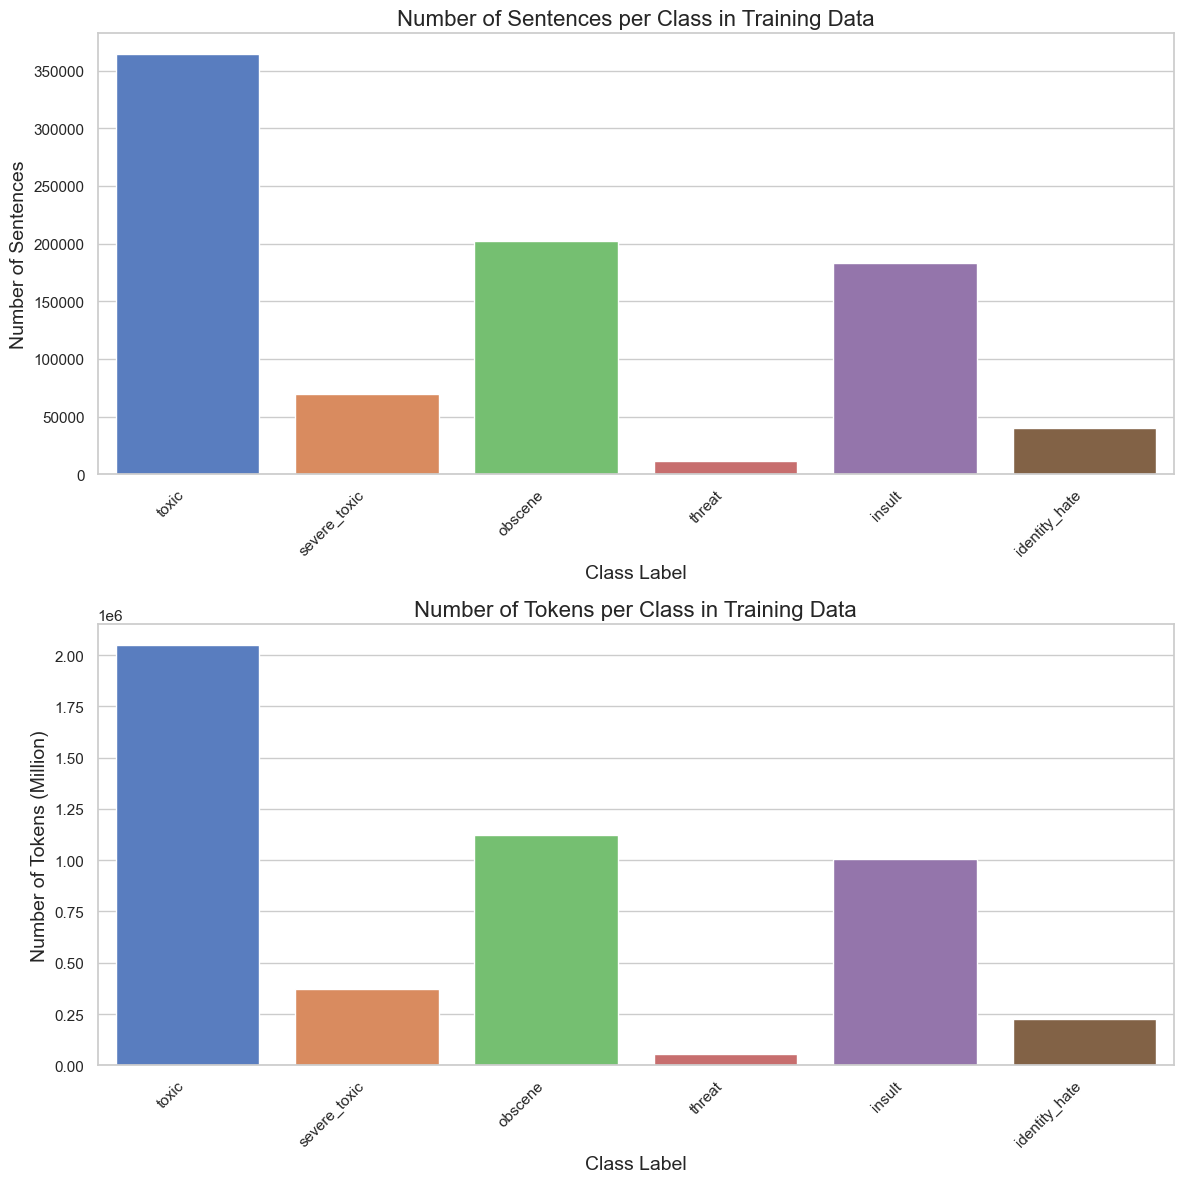

In [26]:
# Set the style for the plot
sns.set(style="whitegrid")

# Plot the number of sentences and tokens per class
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot the number of sentences per class
sentences_plot = sns.barplot(ax=axes[0], x='class_label', y='num_sentences', data=class_counts_df, palette="muted")
sentences_plot.set_title('Number of Sentences per Class in Training Data', fontsize=16)
sentences_plot.set_xlabel('Class Label', fontsize=14)
sentences_plot.set_ylabel('Number of Sentences', fontsize=14)
sentences_plot.set_xticklabels(sentences_plot.get_xticklabels(), rotation=45, ha='right') 

# Plot the number of tokens per class
tokens_plot = sns.barplot(ax=axes[1], x='class_label', y='num_tokens', data=class_counts_df, palette="muted")
tokens_plot.set_title('Number of Tokens per Class in Training Data', fontsize=16)
tokens_plot.set_xlabel('Class Label', fontsize=14)
tokens_plot.set_ylabel('Number of Tokens (Million)', fontsize=14)
tokens_plot.set_xticklabels(tokens_plot.get_xticklabels(), rotation=45, ha='right')  

plt.tight_layout() 
plt.show()
warnings.filterwarnings(action = 'ignore')

### Understanding the Most Common Words

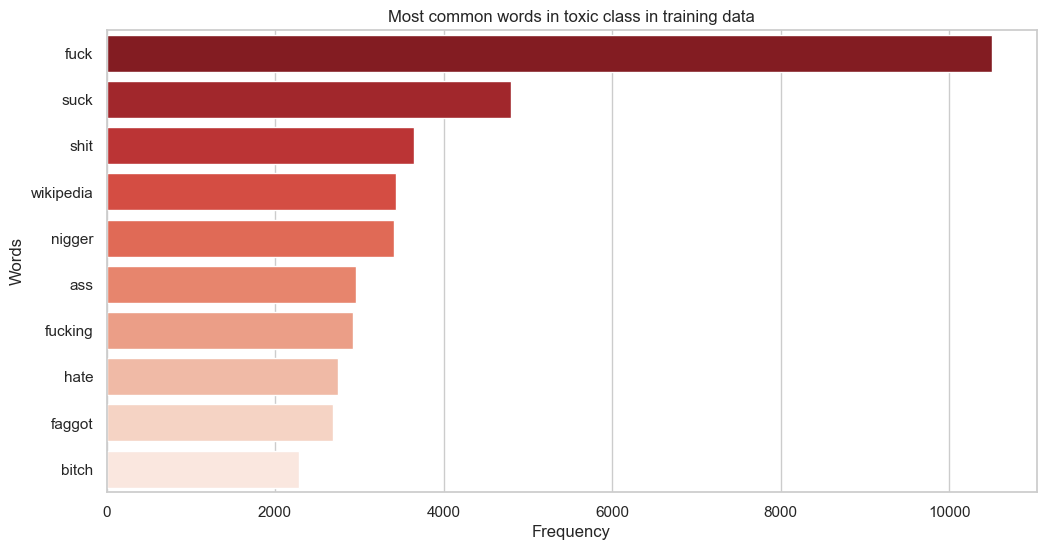

Most common words in toxic class: [('fuck', 10509), ('suck', 4799), ('shit', 3649), ('wikipedia', 3435), ('nigger', 3414), ('ass', 2964), ('fucking', 2925), ('hate', 2744), ('faggot', 2691), ('bitch', 2283)]


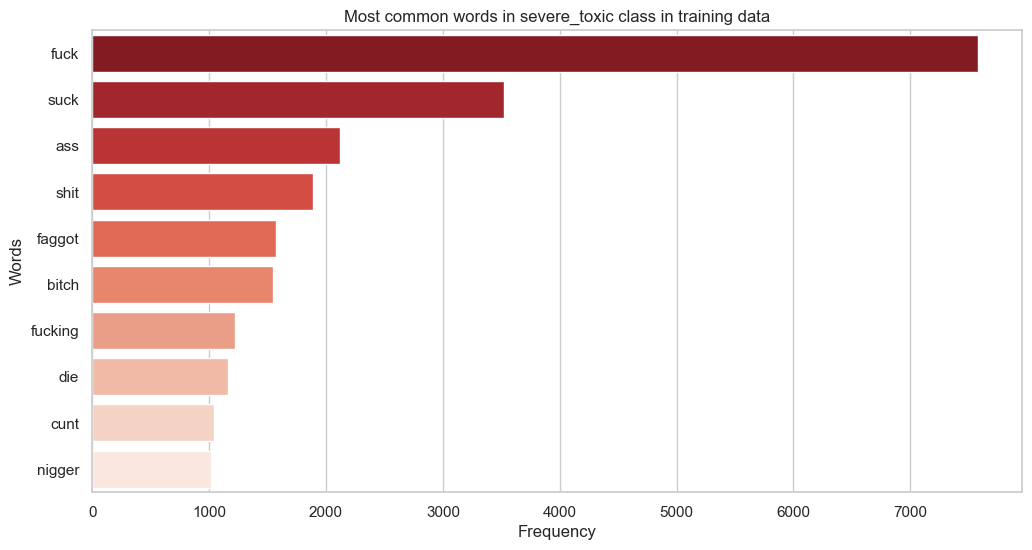

Most common words in severe_toxic class: [('fuck', 7581), ('suck', 3520), ('ass', 2119), ('shit', 1889), ('faggot', 1575), ('bitch', 1544), ('fucking', 1219), ('die', 1165), ('cunt', 1038), ('nigger', 1016)]


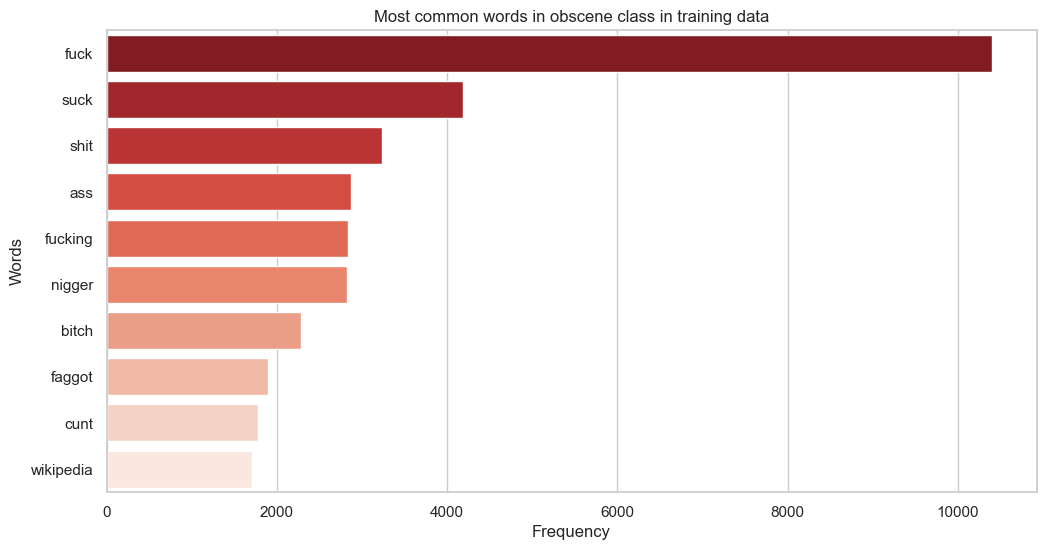

Most common words in obscene class: [('fuck', 10402), ('suck', 4190), ('shit', 3233), ('ass', 2867), ('fucking', 2838), ('nigger', 2828), ('bitch', 2283), ('faggot', 1891), ('cunt', 1784), ('wikipedia', 1708)]


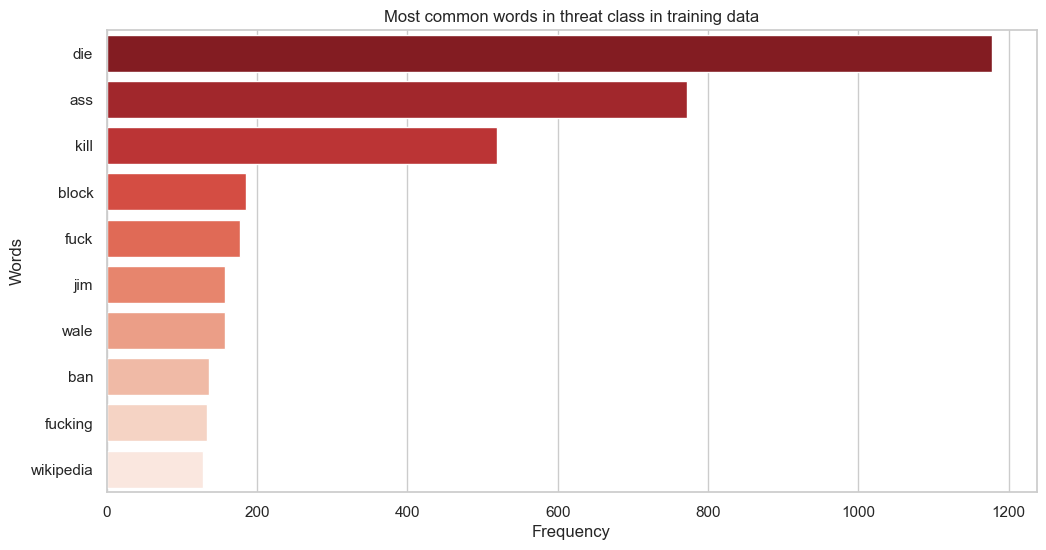

Most common words in threat class: [('die', 1178), ('ass', 772), ('kill', 520), ('block', 185), ('fuck', 178), ('jim', 158), ('wale', 157), ('ban', 136), ('fucking', 134), ('wikipedia', 129)]


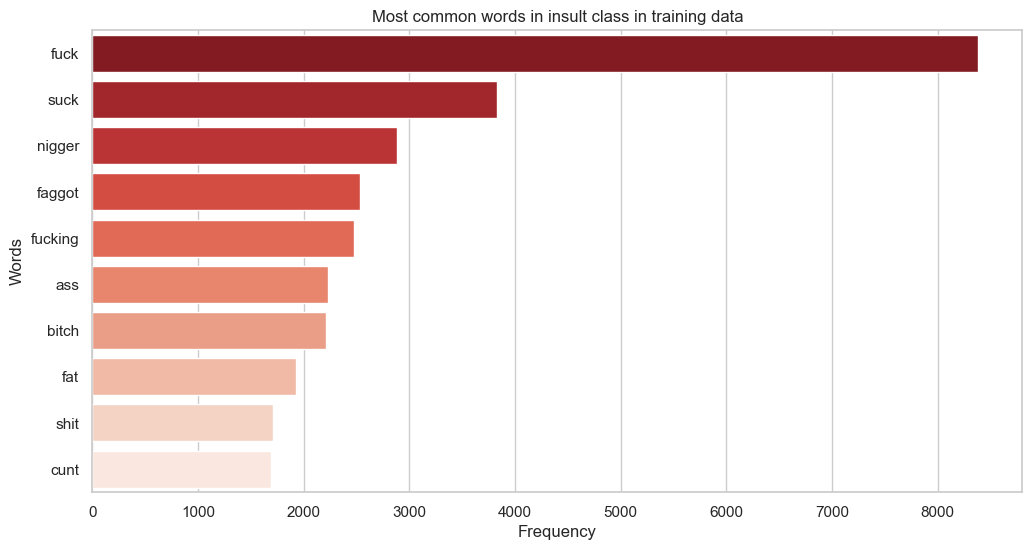

Most common words in insult class: [('fuck', 8381), ('suck', 3833), ('nigger', 2881), ('faggot', 2530), ('fucking', 2478), ('ass', 2226), ('bitch', 2209), ('fat', 1928), ('shit', 1708), ('cunt', 1689)]


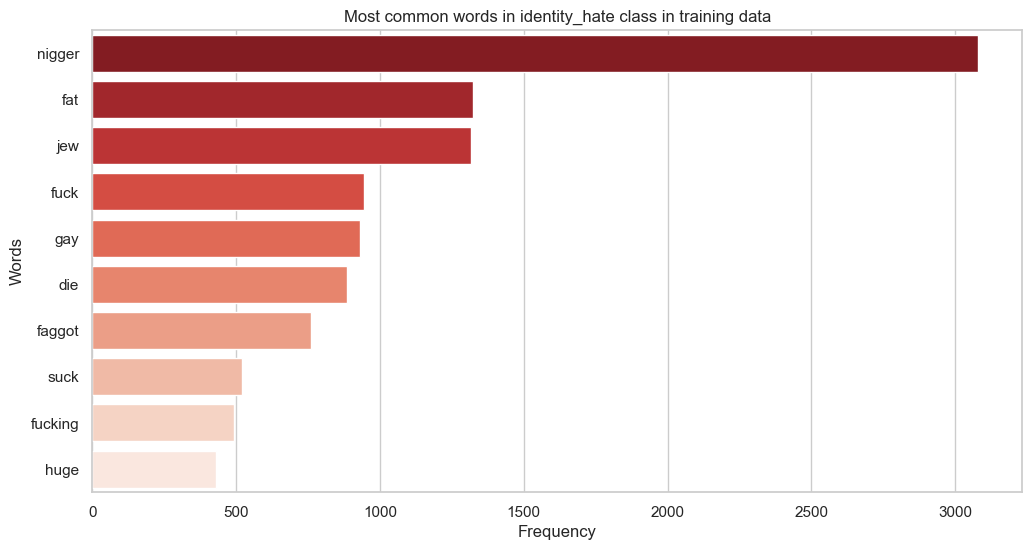

Most common words in identity_hate class: [('nigger', 3080), ('fat', 1323), ('jew', 1315), ('fuck', 944), ('gay', 932), ('die', 885), ('faggot', 760), ('suck', 519), ('fucking', 493), ('huge', 430)]


In [31]:
def plot_common_words(counts, title):
    """
    Plot most common words

    :param counts: list of tuples
    :param title: string
    :return: None
    """
    labels = [word for word, _ in counts]
    freqs = [count for _, count in counts]

    # Use seaborn for a more visually appealing plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=freqs, y=labels, palette="Reds_r")  
    
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(title)
    plt.show()

# Visualise the 10 most common words for each class distribution
for label in class_labels:
    words = []
    for comment in df_train[df_train[label] == 1]['comment_text']:
        words.extend(comment)
    
    most_common_words = Counter(words).most_common(10)
    plot_common_words(most_common_words, f'Most common words in {label} class in training data')
    print(f'Most common words in {label} class: {most_common_words}')
    warnings.filterwarnings(action = 'ignore')


### Exploring Class Distribution and Imbalance 

In [28]:
class_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for column in class_columns:
    class_counts = df[column].value_counts()
    
    print(f"{column.capitalize()} Counts:")
    for index, count in class_counts.items():
        class_label = "Non-" + column if index == 0 else column
        print(f"{class_label}: {count}")
    
    print()

Toxic Counts:
Non-toxic: 144277
toxic: 15294

Severe_toxic Counts:
Non-severe_toxic: 157976
severe_toxic: 1595

Obscene Counts:
Non-obscene: 151122
obscene: 8449

Threat Counts:
Non-threat: 159093
threat: 478

Insult Counts:
Non-insult: 151694
insult: 7877

Identity_hate Counts:
Non-identity_hate: 158166
identity_hate: 1405



---
## Section 3. Feature Extraction

### TF-IDF Implementation

TF-IDF weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).
IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [ ]:
vectoriser = TfTfidfVectorizer()
transformed_output = v.fit_transform(
print(v.vocabulary_)